In [2]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker
import TsModel
import GprModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [25]:
exp22_results = {
    'nn_train_accuracy' : nn_train_accuracy,
    'nn_test_accuracy':nn_test_accuracy,
    'nn_r2s':nn_r2s,
    'nn_time':nn_time,
    'gp_train_accuracy':gp_train_accuracy,
    'gp_test_accuracy':gp_test_accuracy,
    'gp_r2s':gp_r2s,
    'gp_time':gp_time,
    'tsl_train_accuracy' : tsl_train_accuracy,
    'tsl_test_accuracy' :tsl_test_accuracy,
    'tsl_r2s':tsl_r2s,
    'tsl_time': tsl_time,
    'tsc_train_accuracy':tsc_train_accuracy,
    'tsc_test_accuracy':tsc_test_accuracy,
    'tsc_r2s':tsc_r2s,
    'tsc_time':tsc_time
}

In [26]:
#%store exp22_results 

Stored 'exp22_results' (dict)


In [3]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar_x_train.csv')
x_test = pd.read_csv('Data/FES/solar_x_test.csv')
y_train = pd.read_csv('Data/FES/solar_y_train.csv')
y_test = pd.read_csv('Data/FES/solar_y_test.csv')

In [4]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [5]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [8]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=500, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
    
    return neural_network_model

In [9]:
nn_model = do_nn_exp()

Epoch 1/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20443758.0000 - root_mean_squared_error: 4387.4897
Epoch 2/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17379212.0000 - root_mean_squared_error: 3941.3757
Epoch 3/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7060173.0000 - root_mean_squared_error: 2636.6814
Epoch 4/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8752539.0000 - root_mean_squared_error: 2937.4353
Epoch 5/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9595796.0000 - root_mean_squared_error: 3067.1130
Epoch 6/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7202962.5000 - root_mean_squared_error: 2659.1462
Epoch 7/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11689142.0000 - root_mean_squared_error: 3380.0027
Epoch 8/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8086547.5000 - root_mean_squared_error: 2823.6255
Epoch 9/500
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7918612.0000 - root_mean_squared_error: 2766.6882
Epoch 10/500
70/

In [12]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 2556.479 ± 11.854
NN Test RMSE: 535.788 ± 38.84
NN R2: 0.94 ± 0.009
NN Time: 141.326 ± 1.028


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 1.0, 'NN prediction vs true value for testing data')

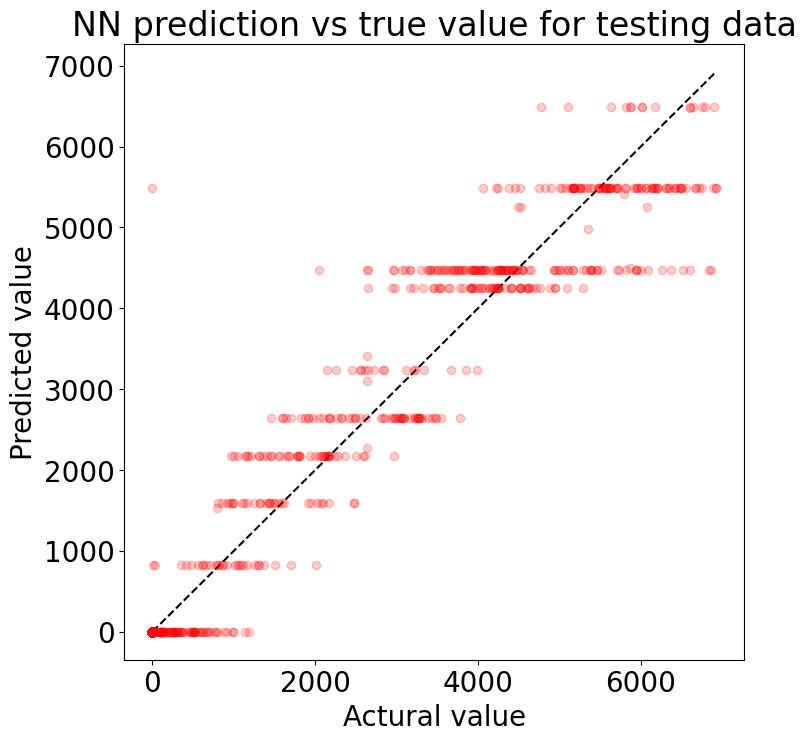

In [10]:
# Visualiza the error

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, nn_model.predict(x_test), 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('NN prediction vs true value for testing data')

In [32]:
#neural_network_model.save('solar_nn.keras')

In [17]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []

for fold in range(number_of_folds):
    
    gpr_model = GprModel.GprModel()
    
    start_time = time.time()
    gpr_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    train_predicted_means_concat = []
    train_predicted_means,_ = gpr_model.predict(x_train, y_train)
    for gpr_prediction_means_i in train_predicted_means:
        train_predicted_means_concat = np.concatenate((train_predicted_means_concat, gpr_prediction_means_i))

    test_predicted_means_concat = []
    test_predicted_means,_ = gpr_model.predict(x_test, y_test)
    for gpr_prediction_means_i in test_predicted_means:
        test_predicted_means_concat = np.concatenate((test_predicted_means_concat, gpr_prediction_means_i))

    train_rmse = root_mean_squared_error(y_train, train_predicted_means_concat)
    test_rmse = root_mean_squared_error(y_test, test_predicted_means_concat)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_predicted_means_concat)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 15908.544302714856
Root Mean Squared Error: 62376.45263950681


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 2565.7590823588052
Root Mean Squared Error: 5130523.618843362


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 2777.2290644442387
Root Mean Squared Error: 105575.42265551008


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 2854.956388369667
Root Mean Squared Error: 252118.23825927475


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 16109.682570407807
Root Mean Squared Error: 534229.2070970238


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 3158.0381556976736
Root Mean Squared Error: 82640.69825288982


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 41518.27147152421
Root Mean Squared Error: 219353.7144494877


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 1656.3418751909412
Root Mean Squared Error: 84389.91497044395


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 4082.9379272786027
Root Mean Squared Error: 112004.00179682102


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\scipy\optimize\_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[1. 1. 1.]
Root Mean Squared Error: 1692.1625367136965
Root Mean Squared Error: 212095.30399118594


In [18]:
gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")

GP Train RMSE: 13858.657 ± 23720.134
GP Test RMSE: 679530.657 ± 1489572.134
GP R2: -560590.385 ± 1648147.768
GP Time: 11.301 ± 0.219


In [8]:
# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

# TS with linear conclusion
tsl_train_accuracy = []
tsl_test_accuracy = []
tsl_r2s = []
tsl_time = []

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_train_accuracy.append(train_rmse)
    tsl_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)


In [20]:
tsl_train_accuracy_mean = np.round(np.mean(tsl_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

TS Linear Train RMSE: 2409.793 ± 18.92
TS Linear Test RMSE: 874.123 ± 37.627
TS Linear R2: 0.84 ± 0.014
TS Linear Time: 0.615 ± 0.125


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

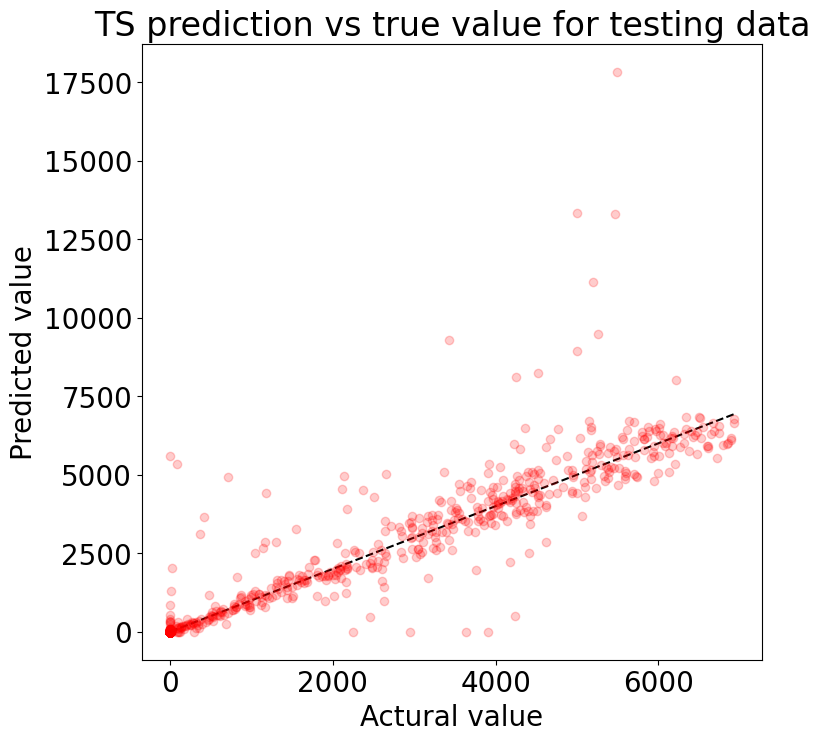

In [60]:
# Visualiza the error

plt.figure(figsize=(8,8))    
plt.plot([min(y_test.to_numpy()),max(y_test.to_numpy())], [min(y_test.to_numpy()),max(y_test.to_numpy())], 'k--')
plt.plot(y_test.to_numpy(), ts_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')

In [9]:
# TS model
# Constant conclusion
tsc_train_accuracy = []
tsc_test_accuracy = []
tsc_r2s = []
tsc_time = []

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_train_accuracy.append(train_rmse)
    tsc_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)

(2209, 150)
[[2.70013988e-14 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.24417522e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.62625145e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.69220172e-07 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.11044374e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.15011851e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2209, 25)
[[2.70013988e-14 1.51166984e-17 1.81624107e-15 ... 9.73533494e-17
  6.89466773e-18 1.34210048e-13]
 [8.24417522e-08 7.21419591e-11 6.89158884e-09 ... 5.44548203e-10
  3.67269782e-11 9.54007718e-07]
 [3.62625145e-07 2.54536111e-06 2.10074064e-10 ... 7.92016106e-10
  3.86822542e-10 5.47143353e-09]
 ...
 [1.69220172e-07 3.33641190e-08 2.60278096e-08 ... 5.02728898e-07
  1.96011

In [10]:
tsc_train_accuracy_mean = np.round(np.mean(tsc_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

TS Constant Train RMSE: 2555.524 ± 6.868
TS Constant Test RMSE: 613.903 ± 10.743
TS Constant R2: 0.921 ± 0.003
TS Constant Time: 0.534 ± 0.095


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

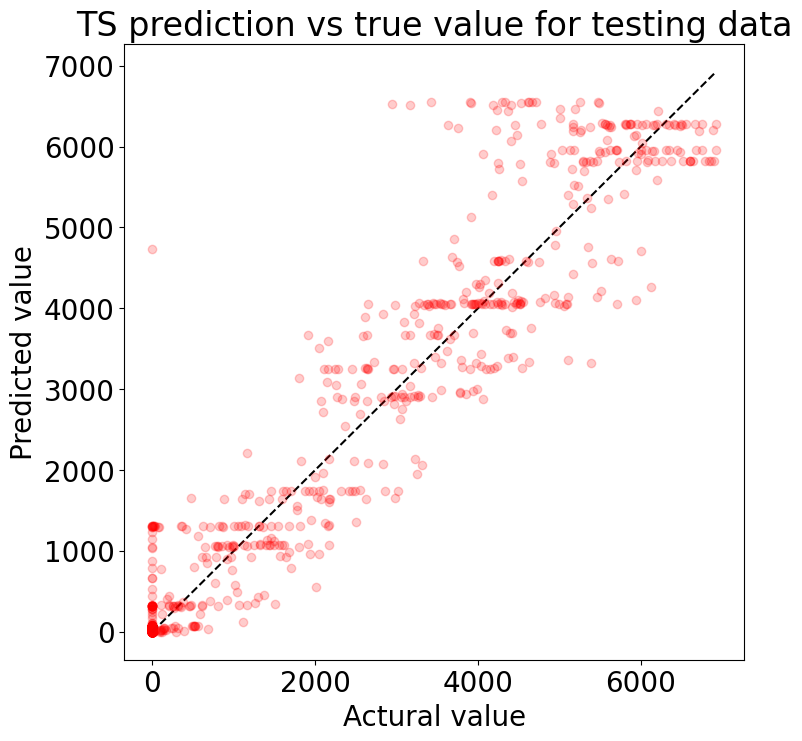

In [13]:
# Visualiza the error
ts_const_pred = ts_relu_wrapper(ts_model.predict(x_test))

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, ts_const_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')